In [33]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from footprint_tune import combo_dust_fp
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import hpid2RaDec

import pandas as pd
import sqlite3
from scipy.stats import binned_statistic

In [2]:
nside=32
fp = combo_dust_fp(nside=nside)
fp_sum=0
for key in fp:
    fp_sum += fp[key]

In [3]:
wfd=np.where(fp['r'] == 1)[0]

In [4]:
wfd_area = wfd.size * hp.nside2pixarea(nside, degrees=True)
wfd_area

19887.90221692381

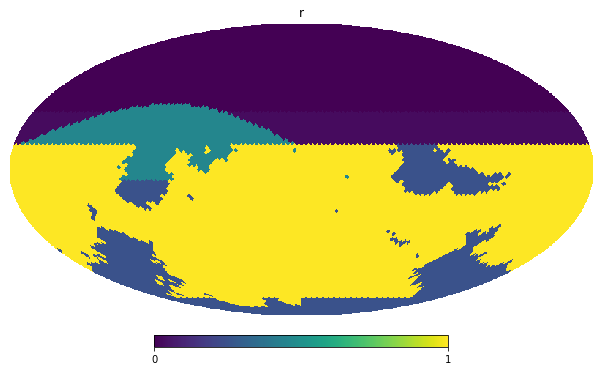

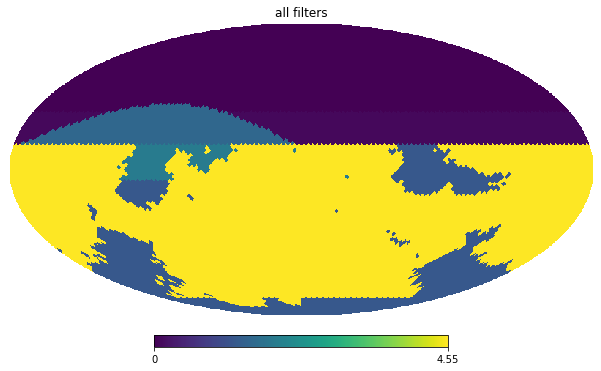

In [5]:
hp.mollview(fp['r'], title='r')
hp.mollview(fp_sum, title='all filters')

In [6]:
# OK, he's how we can do a quick estimate of how well a survey will perform for an arbitrary footprint

In [7]:
dbFile = 'baseline_nexp2_v1.6_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [8]:
bundleList = []
sql = 'note not like "DD%"'
metric = metrics.CountMetric(col='night')
slicer = slicers.HealpixSlicer(nside=nside)
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()                  
                  

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Querying database SummaryAllProps with constraint note not like "DD%" for columns ['night', 'fieldRA', 'fieldDec']
Found 1970611 visits
Running:  ['opsim_Count_night_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "note not like "DD%"" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 647.52  dipole: lon: 140.478, lat: -87.0216, amp: 198.179
  mono, lon, lat, amp


Plotting complete.


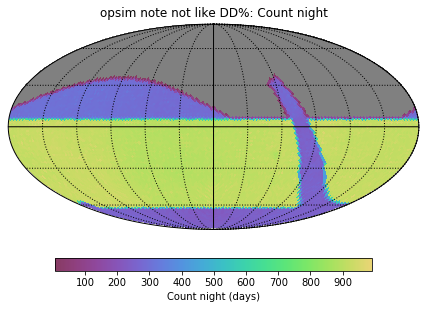

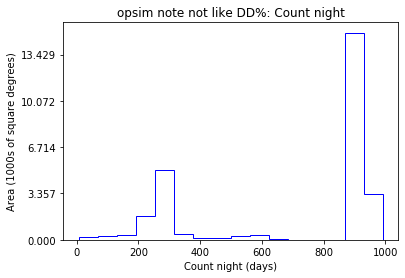

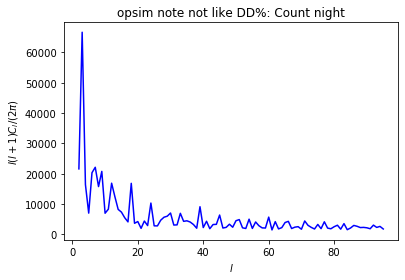

In [9]:
bg.plotAll(closefigs=False)

In [10]:
etendu_sum = bundleList[0].metricValues.sum()
etendu_sum

5782108.0

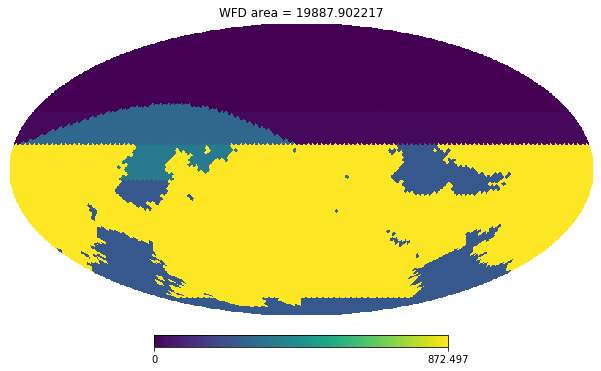

In [11]:
# Should be a slightlt optimistic estimate because it doesn't include the etendue lost to dithering outside the desired footprint
# wouldn't be tough to estimate if we really wanted to.
fp = combo_dust_fp()
wfd=np.where(fp['r'] == 1)[0]
wfd_area = wfd.size * hp.nside2pixarea(nside, degrees=True)
fp_sum=0
for key in fp:
    fp_sum += fp[key]
scaled_map = fp_sum/fp_sum.sum() * etendu_sum
hp.mollview(scaled_map, title='WFD area = %f' % wfd_area)

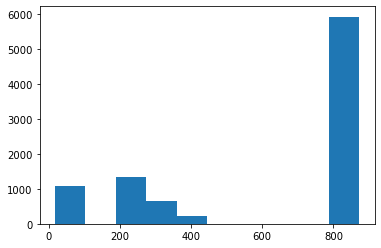

In [12]:
_temp = plt.hist(scaled_map[np.where(scaled_map > 0)])

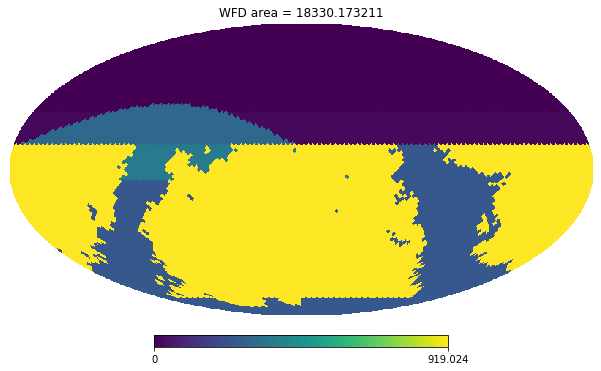

In [13]:
# OK, let's take out the bulge and bridge.  This might be getting too uneven with RA-dsitribution, but whatever
fp = combo_dust_fp(nside=nside, outer_bridge_width=0., bulge_lon_span=0., bulge_alt_span=0.,  ses_dist_eclip=0.)
wfd=np.where(fp['r'] == 1)[0]
wfd_area = wfd.size * hp.nside2pixarea(nside, degrees=True)
fp_sum=0
for key in fp:
    fp_sum += fp[key]
scaled_map = fp_sum/fp_sum.sum() * etendu_sum
hp.mollview(scaled_map, title='WFD area = %f' % wfd_area)

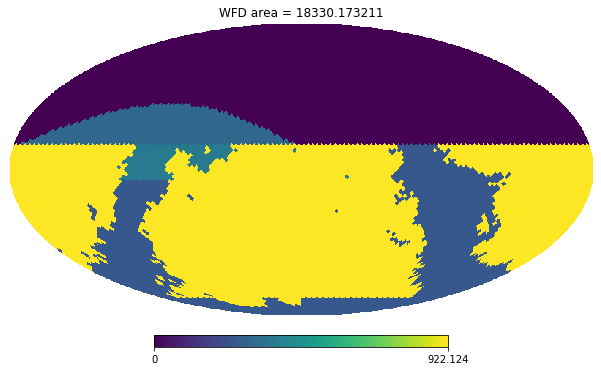

In [14]:
# ok, now remove the northern stripe too
fp = combo_dust_fp(nside=nside, outer_bridge_width=0., bulge_lon_span=0.,
                   bulge_alt_span=0.,  ses_dist_eclip=0., 
                  north_weights={'g': 0.0, 'r': 0.0, 'i': 0.0}, north_limit=30.)
wfd=np.where(fp['r'] == 1)[0]
wfd_area = wfd.size * hp.nside2pixarea(nside, degrees=True)
fp_sum=0
for key in fp:
    fp_sum += fp[key]
scaled_map = fp_sum/fp_sum.sum() * etendu_sum
hp.mollview(scaled_map, title='WFD area = %f' % wfd_area)

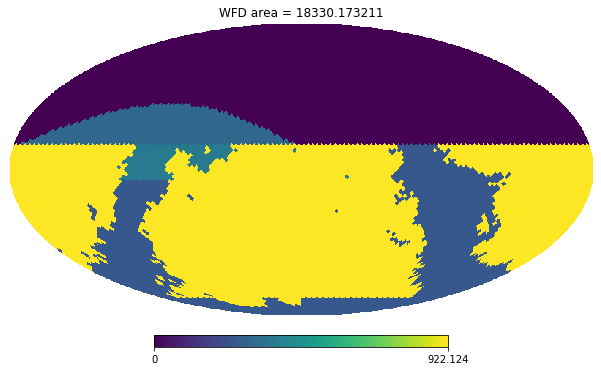

In [15]:
# Shrink the exgal and keep bulge 
fp = combo_dust_fp(nside=nside, outer_bridge_width=0., bulge_lon_span=0.,
                   bulge_alt_span=0.,  ses_dist_eclip=0., 
                  north_weights={'g': 0.0, 'r': 0.0, 'i': 0.0}, north_limit=30.)
wfd=np.where(fp['r'] == 1)[0]
wfd_area = wfd.size * hp.nside2pixarea(nside, degrees=True)
fp_sum=0
for key in fp:
    fp_sum += fp[key]
scaled_map = fp_sum/fp_sum.sum() * etendu_sum
hp.mollview(scaled_map, title='WFD area = %f' % wfd_area)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Querying database SummaryAllProps with constraint note not like "DD%" for columns ['night', 'fieldRA', 'fieldDec']
Found 1975275 visits
Running:  ['opsim_Count_night_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "note not like "DD%"" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 528.265  dipole: lon: 59.7648, lat: -84.002, amp: 353.835
  mono, lon, lat, amp


Plotting complete.


5789197.0

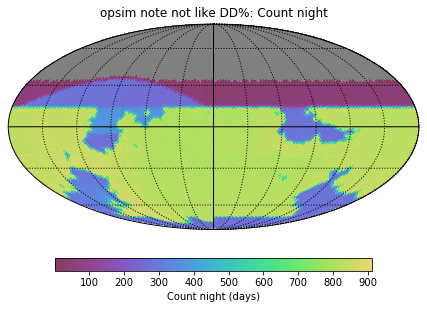

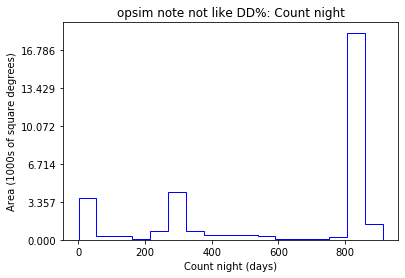

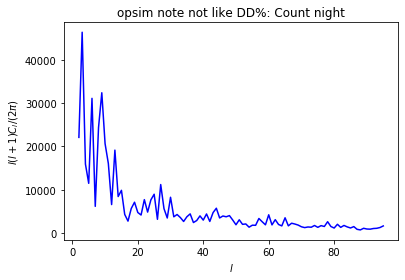

In [16]:
dbFile = 'combo_dust_nexp2_v1.6_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

bundleList = []
sql = 'note not like "DD%"'
metric = metrics.CountMetric(col='night')
slicer = slicers.HealpixSlicer(nside=nside)
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()                

bg.plotAll(closefigs=False)

etendu_sum = bundleList[0].metricValues.sum()
etendu_sum

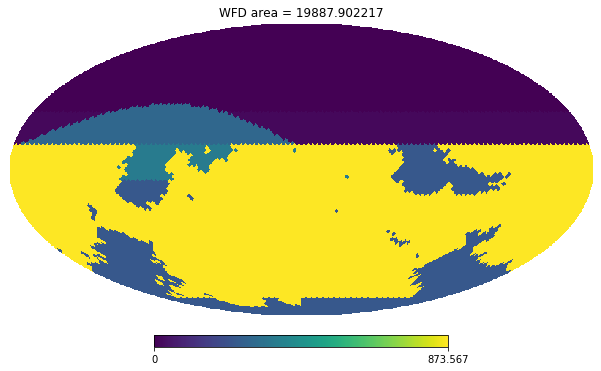

In [17]:
fp = combo_dust_fp()
wfd=np.where(fp['r'] == 1)[0]
wfd_area = wfd.size * hp.nside2pixarea(nside, degrees=True)
fp_sum=0
for key in fp:
    fp_sum += fp[key]
scaled_map = fp_sum/fp_sum.sum() * etendu_sum
hp.mollview(scaled_map, title='WFD area = %f' % wfd_area)

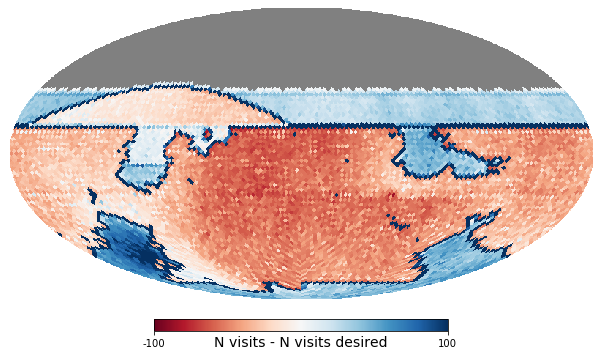

In [18]:
# Red means we lack observations, blue means too many observations, white is just right
hp.mollview(bundleList[0].metricValues - scaled_map, min=-100, max=100, cmap='RdBu', 
           title='', unit='N visits - N visits desired')

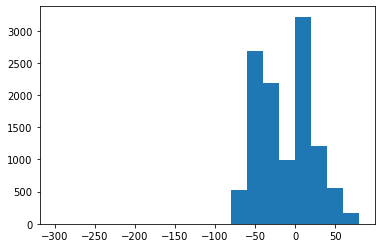

In [19]:
_temp = plt.hist(bundleList[0].metricValues - scaled_map, bins=np.arange(-300,100, 20))

Text(0, 0.5, 'N obs')

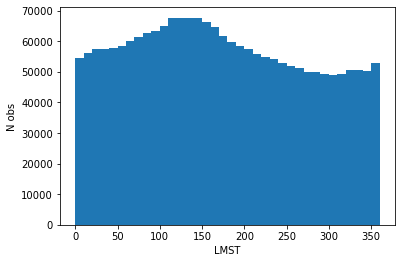

In [50]:
bins = np.arange(0,365, 10)
conn = sqlite3.connect('baseline_nexp2_v1.6_10yrs.db')
df = pd.read_sql('select observationStartLST from summaryallprops ;', conn)
conn.close()

_tmp = plt.hist(df['observationStartLST'], bins=bins)
plt.xlabel('LMST')
plt.ylabel('N obs')

Text(0, 0.5, 'N obs')

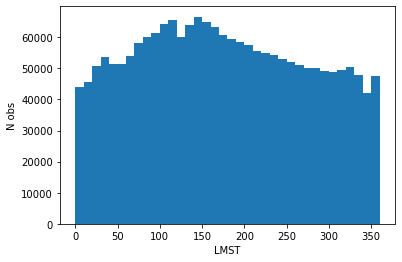

In [51]:

conn = sqlite3.connect('baseline_nexp2_v1.6_10yrs.db')
df = pd.read_sql('select observationStartLST from summaryallprops where note not like "DD%";', conn)
conn.close()
_tmp = plt.hist(df['observationStartLST'], bins=bins)
plt.xlabel('LMST')
plt.ylabel('N obs')

In [52]:
fp = combo_dust_fp()
ra,dec = hpid2RaDec(nside, np.arange(fp['r'].size))
fp_sum=0
for key in fp:
    fp_sum += fp[key]

bin_sum, bin_edges, binnumber = binned_statistic(ra, fp_sum, statistic=np.sum, bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

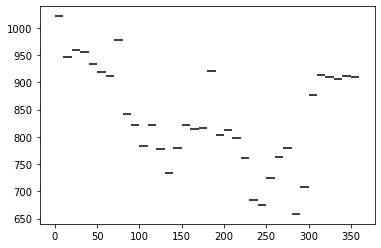

In [54]:
plt.hlines(bin_sum, bin_edges[:-1], bin_edges[1:])